In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# the following is just a workaround because I'm using jupyter within pycharm and have to find a
# work around
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from src.eda_utils import eda

In [11]:
# relative link to location of database
link = "sqlite:////mnt/c/Users/lenovo/Documents/GitHub/Discourse_eda/discourse_forums_dbs/openhardware.science.db"
data = eda(db_link = link, table_name = "post")
data.df_from_json(left_col = "post_id", right_col = "id")

## Some Basic Eda
Looking at the basic distributions of posts per users, topics per user etc.

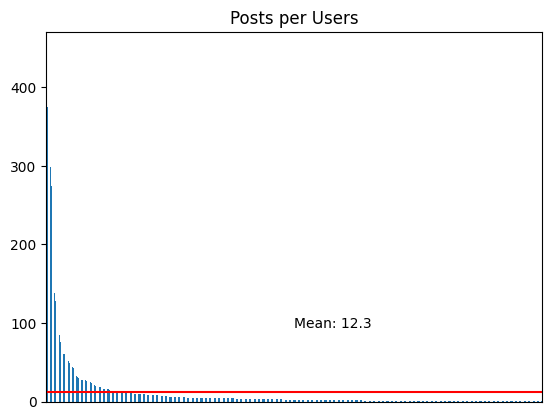

In [12]:
data.show_cat_histogram("username", "Posts per Users")

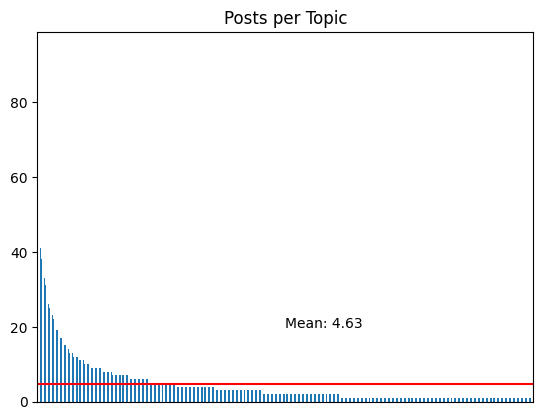

In [14]:
data.show_cat_histogram("topic_id_x", "Posts per Topic")

In [15]:
data.get_like_column()
df = data.return_df()
reply_mean = df["reply_count"].mean()
reads_mean = df["reads"].mean()
readers_mean = df["readers_count"].mean()
like_mean = df['likes'].mean()
print(f"The average post is read {reads_mean.round(2)} times by {readers_mean.round(2)} users, and receives {reply_mean.round(2)} replies as well as {like_mean.round(2)} likes")

The average post is read 19.71 times by 18.71 users, and receives 0.34 replies as well as 1.25 likes


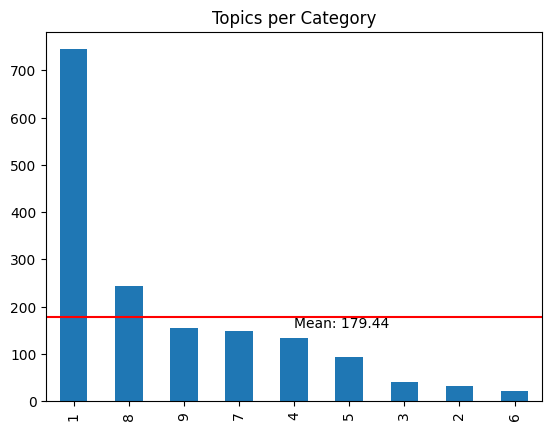

In [16]:
topic = eda(db_link = link, table_name = "topic")
topic.show_cat_histogram("category_id", "Topics per Category", ignore_ticks = False)

In [50]:
cat = eda(db_link = link, table_name = "category")
# there is double id column so little workaround
cat_df = cat.return_df()
cat_df.rename(columns = {"id": "num_id"}, inplace = True)
cat.overwrite_data(cat_df)
cat.df_from_json(left_col = 'category_id', right_col = 'id')
cat.return_df()[['num_id', 'category_id', 'name']]

,num_id,category_id,name
0,1,6,General
1,2,51,Events
2,3,54,Projects
3,4,9,Communities
4,5,46,Latino America y Caribe
5,6,43,GOSH Skill Share
6,7,27,Opportunities
7,8,42,Gatherings
8,9,41,Community Governance


In [18]:
df = data.return_df().merge(topic.return_df()[['topic_id', 'category_id']],
                       how = 'left',
                       left_on = 'topic_id_y',
                      right_on = 'topic_id')

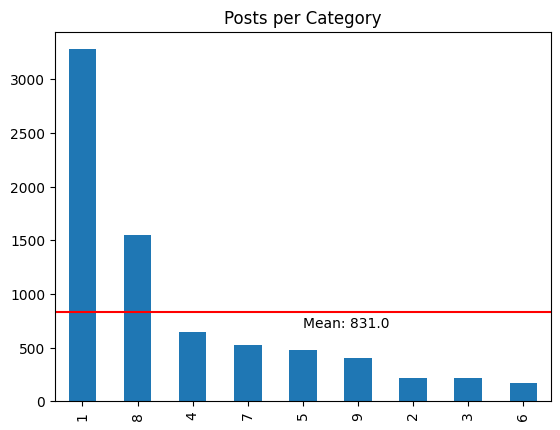

In [19]:
eda.bar_plot(df.category_id.value_counts(), "Posts per Category", ignore_ticks = False)

Some observations:
- Category 1 (General) most posts along with 8 (Gatherings).
- Cat 6 (very speficic application; least posts

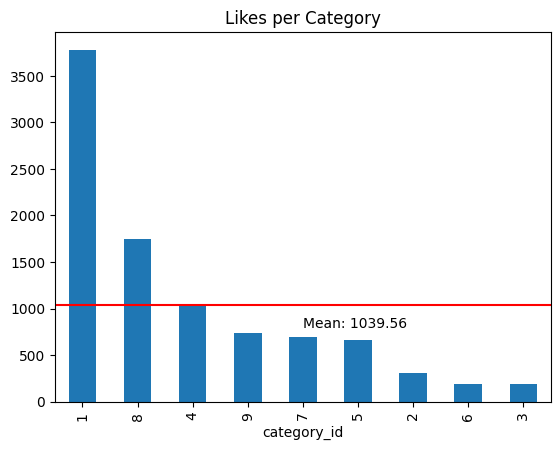

In [20]:
eda.bar_plot(df.groupby("category_id")['likes'].sum().sort_values(ascending = False),
            "Likes per Category", ignore_ticks = False)


## A closer look at the trust level of users

Check this [link](https://blog.discourse.org/2018/06/understanding-discourse-trust-levels/).

There are 5 different Trust Levels:

* Level 0: New
* Level 1: Basic
* Level 2: Member
* Level 3: Regular
* Level 4: Leader

Descriptions on the categories can be found in the link above. Essentially your actions as a user a limited your cateogory.
Higher ranked users can do more

Text(0.5, 1.0, 'Likes per Trust Level')

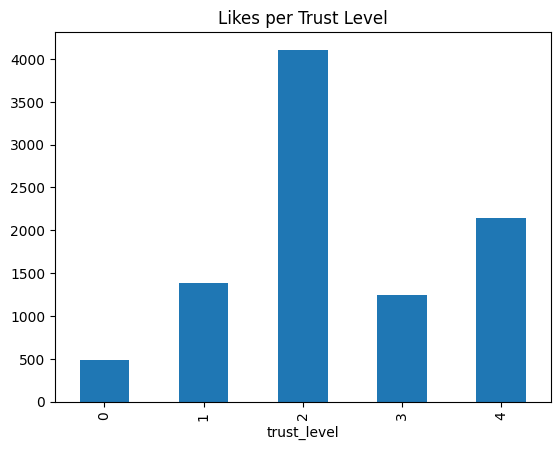

In [22]:
# likes per trust level
import matplotlib.pyplot as plt
df.groupby('trust_level')['likes'].sum().plot(kind = 'bar')
plt.title("Likes per Trust Level")

Text(0.5, 1.0, 'Users per Trust Level')

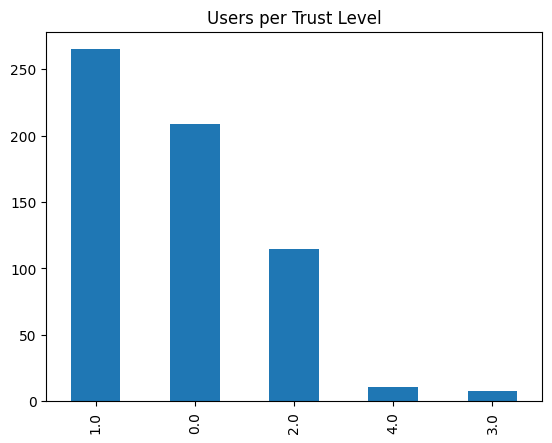

In [23]:
# however a small number of users in the higher groups
df.groupby('username')['trust_level'].mean().value_counts().plot(kind = 'bar')
plt.title("Users per Trust Level")

Text(0.5, 1.0, 'Post per Trust Level')

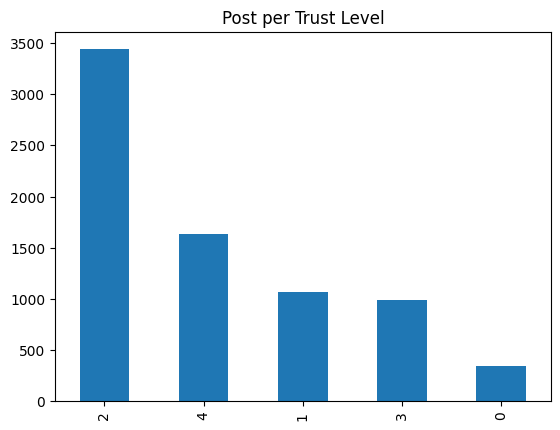

In [24]:
# however post by trust_level
df['trust_level'].value_counts().plot(kind = 'bar')
plt.title("Post per Trust Level")

Text(0.5, 1.0, 'Average likes per User per Trust Level')

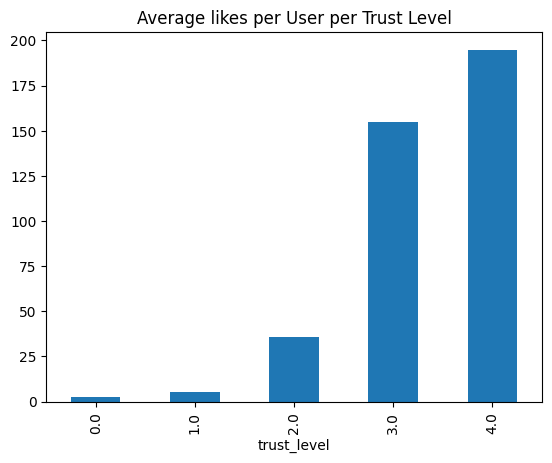

In [25]:
import pandas as pd
user_df = pd.merge(df.groupby("username")['likes'].sum().reset_index(), df.groupby("username")['trust_level'].mean().reset_index())
user_df.groupby("trust_level")['likes'].mean().plot(kind = 'bar')
plt.title("Average likes per User per Trust Level")

Text(0.5, 1.0, 'Average posts per Users, by Trust Level')

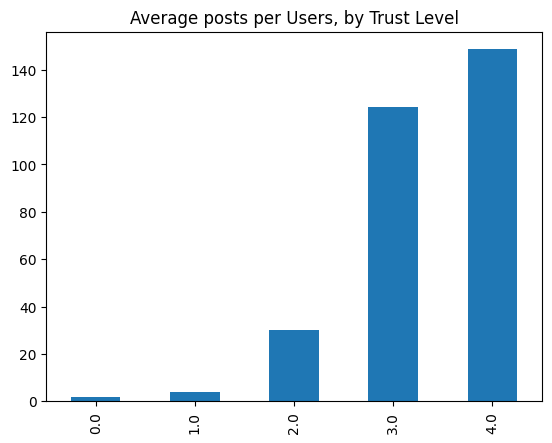

In [26]:
(df.trust_level.value_counts() / df.groupby('username')['trust_level'].mean().value_counts()).plot(kind = 'bar')
plt.title("Average posts per Users, by Trust Level")

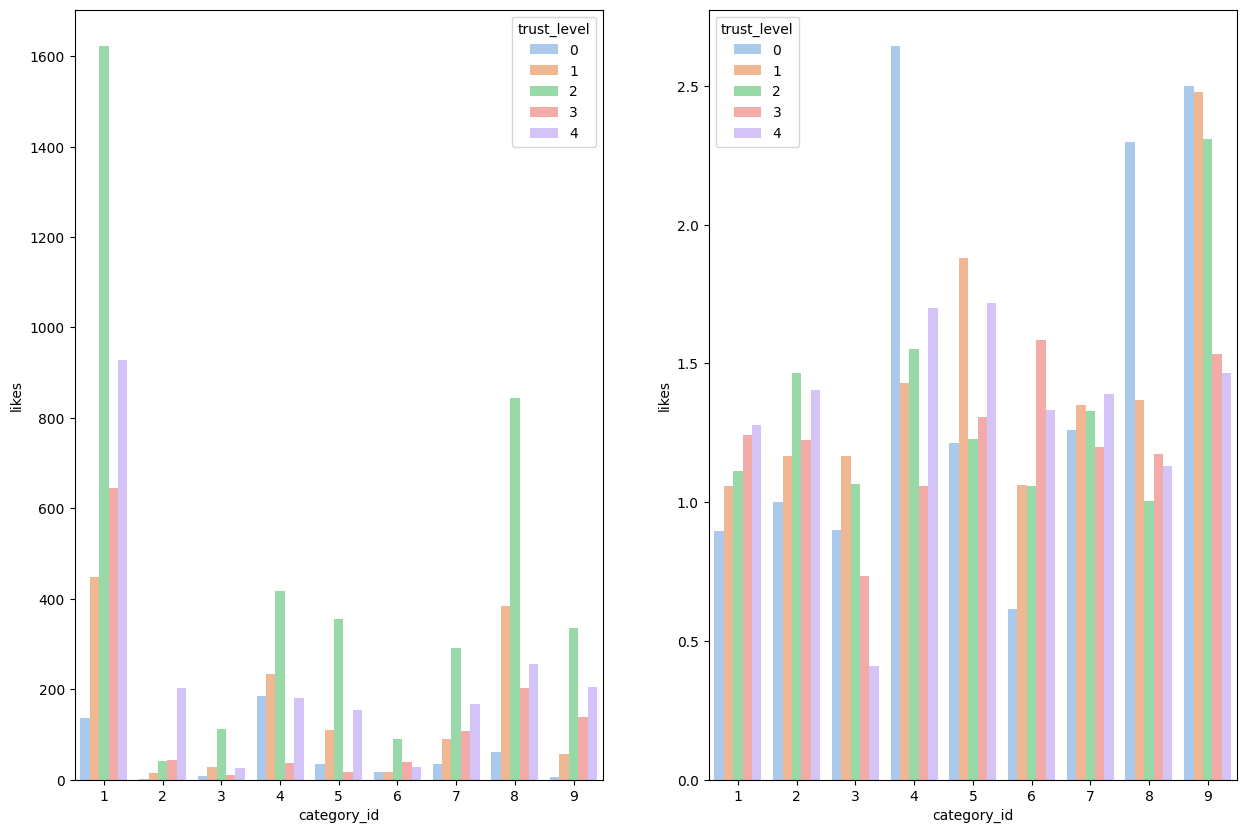

In [28]:
import seaborn as sns
def grouped_bar_plot(in_df, x, y, pal):
    fig, ax =plt.subplots(1,2, figsize = (15,10))
    sns.barplot(data=in_df, x =x, y=y, estimator = "sum", hue='trust_level', errorbar = None, ax = ax[0], palette = pal)
    sns.barplot(data=in_df, x =x, y=y, estimator = "mean", hue='trust_level',errorbar = None,ax = ax[1], palette = pal)

grouped_bar_plot(df, "category_id", "likes", 'pastel')

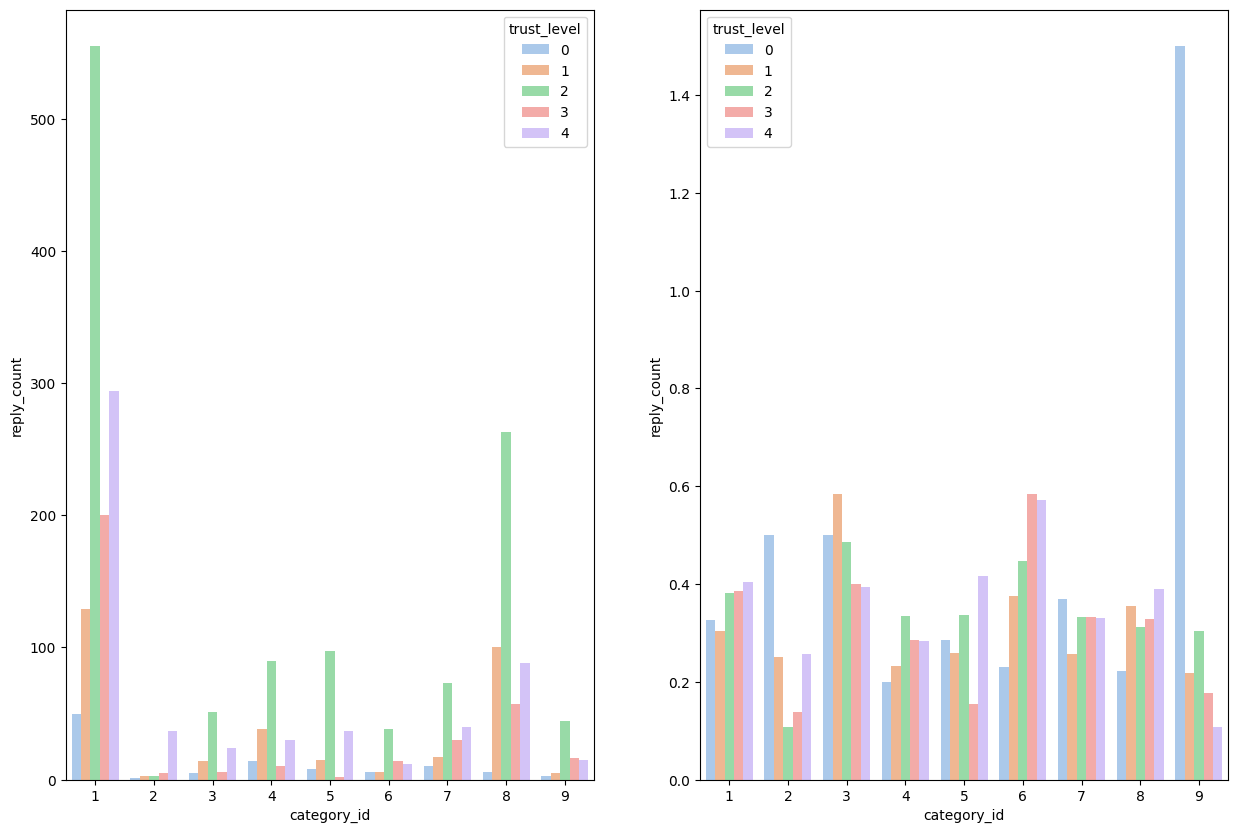

In [29]:
grouped_bar_plot(df, "category_id", "reply_count", 'pastel')

Text(0.5, 1.0, 'Post per Category per Trust Level')

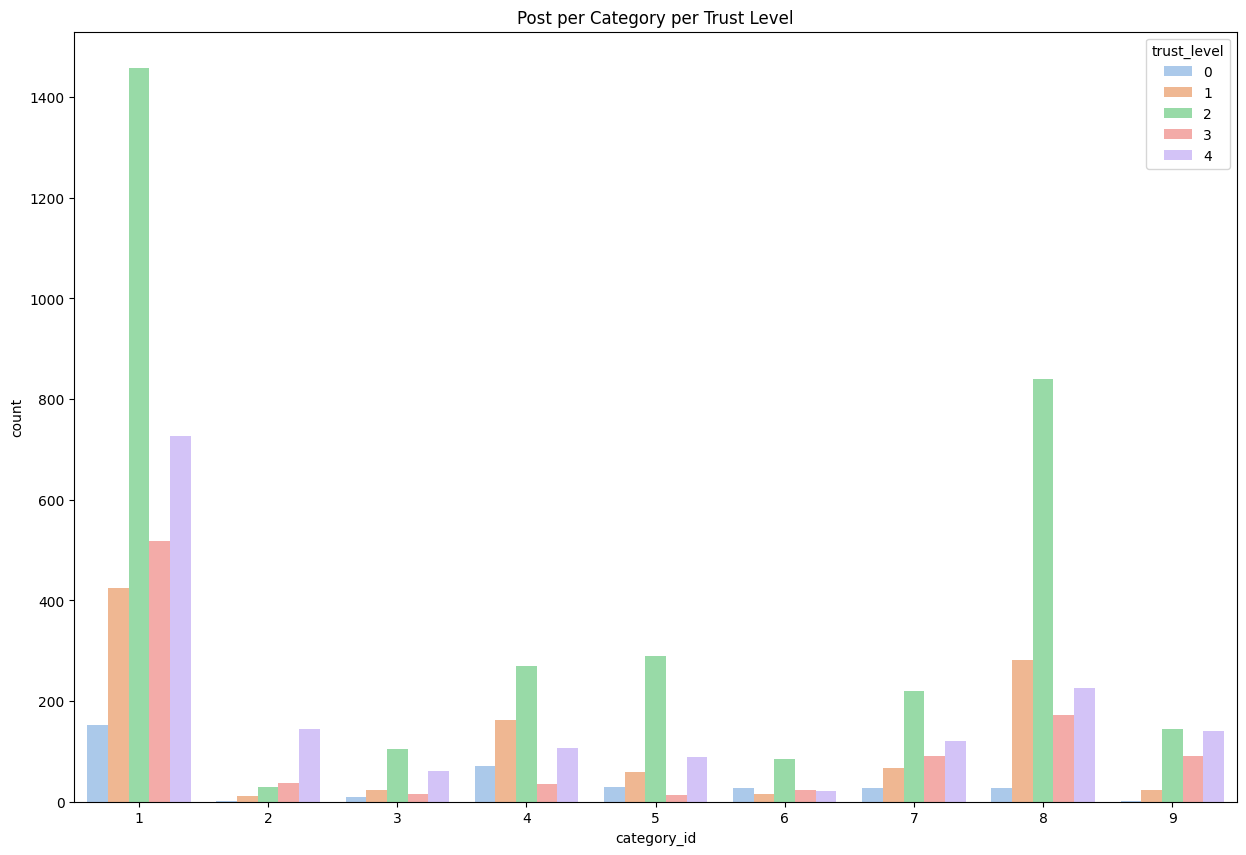

In [30]:
plt.figure(figsize = (15,10))
sns.countplot(data=df, x ='category_id', hue='trust_level', palette = 'pastel')
plt.title("Post per Category per Trust Level") #this one in percentage tambien

A few notes:
- The distribution of Users per Trust Level is very uneven. Higher trust levels will have very little users but a high number of activity, and a high number of reward -> likes etc.
We will want to normalize a few things when moving forward
- Number of posts: A user can post more than another. In some cases this will be something we want to capture. And in other cases this might be something we want to normalize (likes per user). Also some categories have more posts etc

Then we already have some good measures!

In [31]:
# one last cool measure -> reply to trust level -> interaction across users -> normalize to get percents
user_trust_df = df.groupby('username')['trust_level'].mean().reset_index()
df = df.merge(user_trust_df, how = 'left', left_on = "reply_to_user.username", right_on = 'username', suffixes = (None, "_reply"))
test = (df.groupby(['trust_level'])['trust_level_reply']
                     .value_counts(normalize = True)
                    .rename('percentage')
                    .reset_index())

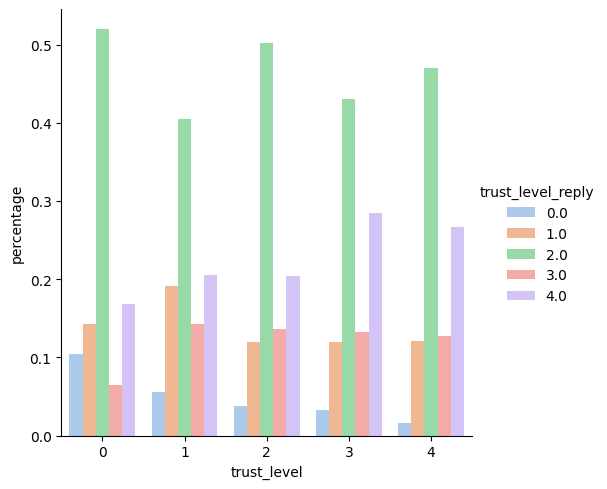

In [32]:
sns.catplot(data=test, x = 'trust_level', y = "percentage",
            hue='trust_level_reply', kind = 'bar', palette='pastel')

Basically what this plot shows, is the the trust level of users that users, sorted by trust level reply to.
_Take-away:_ Most replies are to users from trust level 2. Makes sense as these users are responsible for the most posts. Other minor observations:

- Users from Trust Level 0 reply the most to their own trust level (otherwise super low).


## Networks
The following provides a small overview over different types of networks observed in the data.
For example how do users interact with each other based on a network of replies. And is the interaction dependent on the trust level as well?

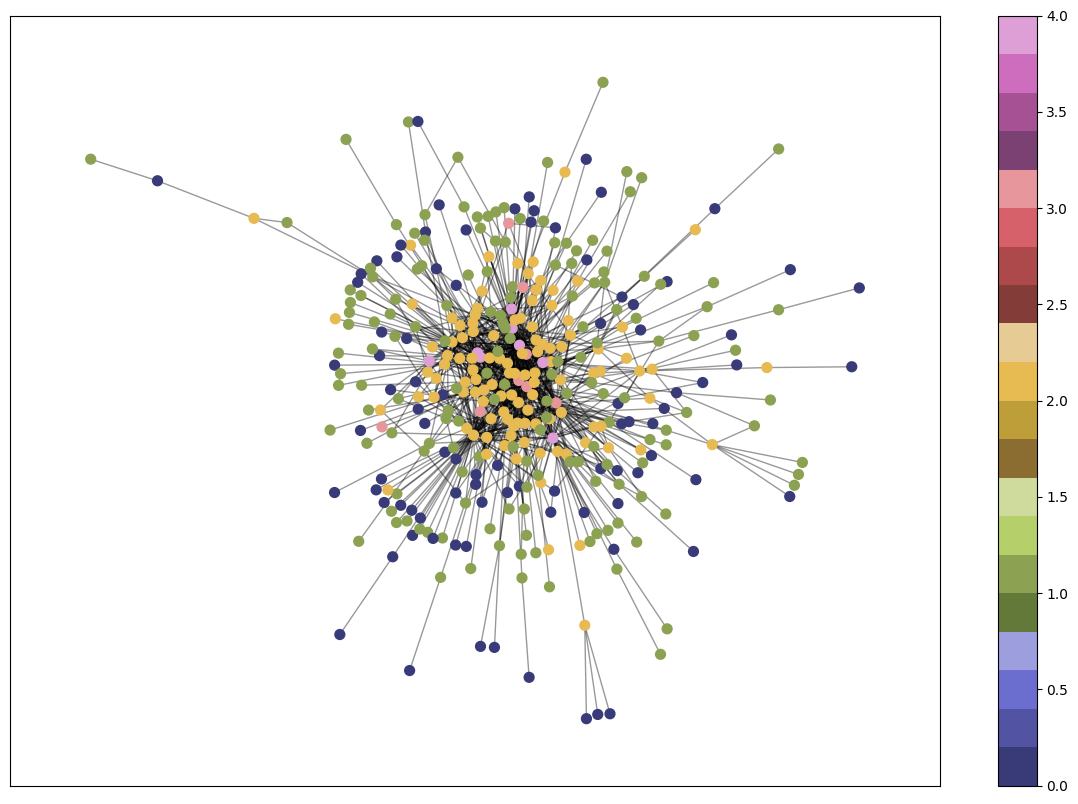

In [33]:
from src.network_utils import network_eda
# User-User network - based on replies
# two users are connected if one of them replied to the other
graph = network_eda(df)
graph.user_graph()
graph.remove_selfloops()
graph.remove_nan_nodes() # if post wasnt a reply -> quite frequently, will have to find a way of including these
graph.remove_isolated_nodes() # remove isolated nodes -> nodes that only interacted with themselves (or never)
graph.add_trust_level() # adds trust level as nodes attribute
graph.group_graph_plot(color = "trust_level") # only plots the largest cc

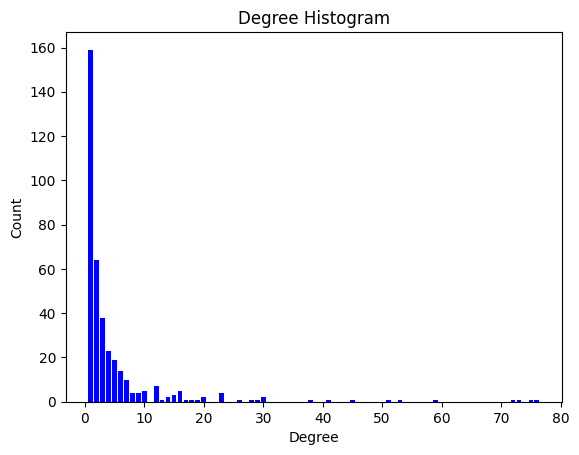

In [34]:
graph.degree_histogram()

In [36]:
import networkx as nx
degree = dict(nx.degree(graph.get_graph()))
graph.sort_dict(degree)

{'julianstirling': 76,
 'gbathree': 75,
 'amchagas': 73,
 'dusjagr': 72,
 'hpy': 59,
 'kaspar': 53,
 'jcm80': 51,
 'jarancio': 45,
 'briannaljohns': 41,
 'marinappdf': 38,
 'nanocastro': 30,
 'thomasmboa': 30,
 'ryanfobel': 29,
 'hikinghack': 28,
 'Rachel': 26,
 'naikymen': 23,
 'shannond': 23,
 'juanmagararc': 23,
 'paz': 23,
 'Harold': 20,
 'laola': 20,
 'juanpedro.maestre': 19,
 'vektor': 18,
 'jmwright': 17,
 'rbowman': 16,
 'Tobey': 16,
 'ffederici': 16,
 'Zengirl2': 16,
 'gpereyrairujo': 16,
 'marbasch': 15,
 'unixjazz': 15,
 'oli.keller': 15,
 'adrianMolecule': 14,
 'leosehn': 14,
 'biomakers_lab': 13,
 'rpez': 12,
 'solstag': 12,
 'scientist': 12,
 'Chardso': 12,
 'sjacques': 12,
 'biomurph': 12,
 'punkish': 12,
 'Javier': 10,
 'gaudi': 10,
 'tiberiusb': 10,
 'Andriy': 10,
 'ymi': 10,
 'jpearce': 9,
 'Juliencolomb': 9,
 'pablocremades': 9,
 'Pollock': 9,
 'lizbarry': 8,
 'bhaugen': 8,
 'szroboman_opentrons': 8,
 'small_peanut': 8,
 'juul': 7,
 'Tanguy': 7,
 'gamelmag': 7,
 'tar

Text(0.5, 1.0, 'Distribution of Eigenvector Centrality')

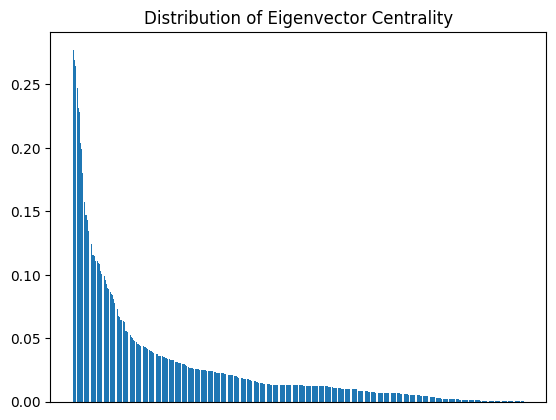

In [37]:
eigen = nx.eigenvector_centrality(graph.get_graph())
eigen = graph.sort_dict(eigen)
plt.bar(range(len(eigen)), list(eigen.values()), align='center')
plt.xticks([])
plt.title("Distribution of Eigenvector Centrality")

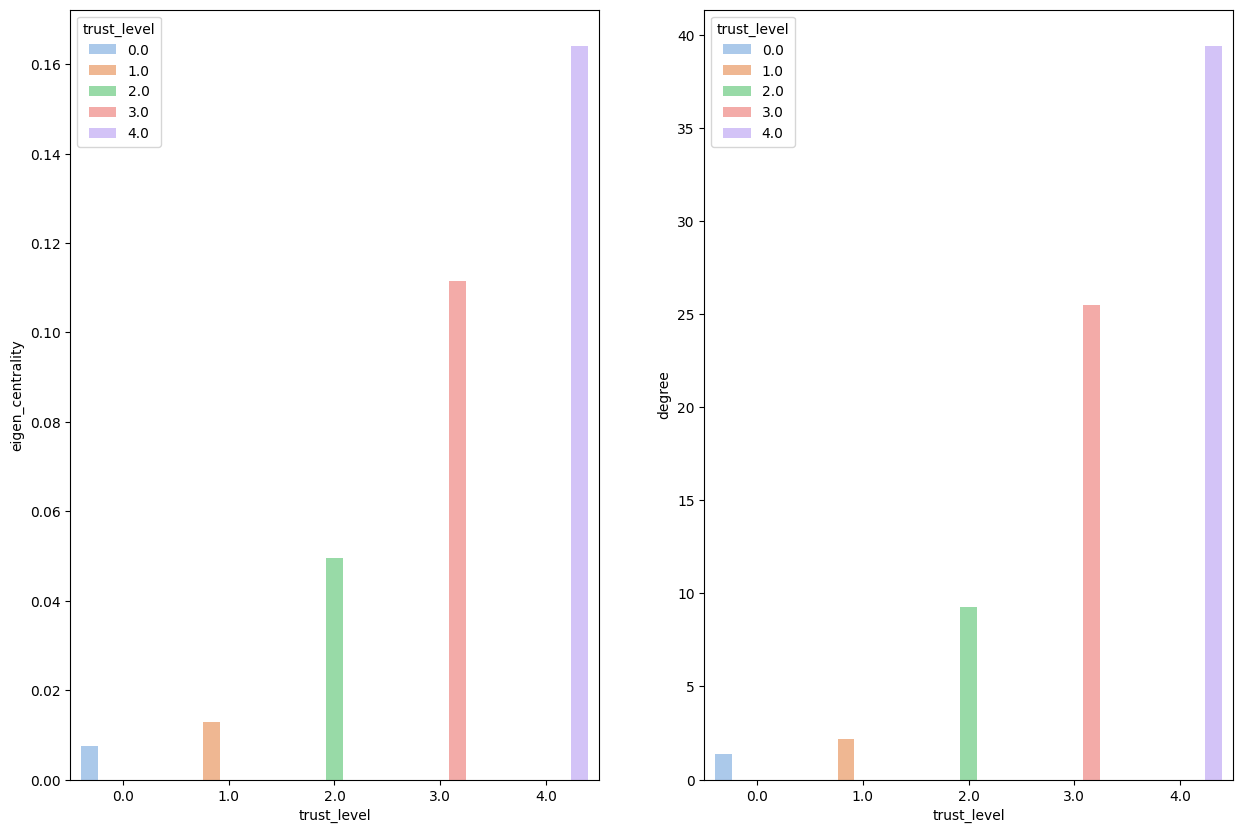

In [40]:
# check centrality measures in more detail
G = graph.get_graph()
degree = dict(G.degree())
attr_list = [eigen, degree]
name_list = ['eigen_centrality', 'degree']
for counter, item in enumerate(attr_list):
    nx.set_node_attributes(G, item, name = name_list[counter])
graph_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()

# plot the results
fig, ax =plt.subplots(1,2, figsize = (15,10))
for counter, variable in enumerate(name_list):
    sns.barplot(data = graph_df, x = "trust_level", y = variable , hue = "trust_level",
                errorbar=None,
           palette = "pastel", ax = ax[counter])

Of course there are differences in the two y-axises; but as they scale almost hte same we can see the only difference with that for both trustlevels 2 and 3 the eigen centrality is higher than the degree. Indicator that they are connected.

<AxesSubplot: xlabel='category_id', ylabel='eigen_centrality'>

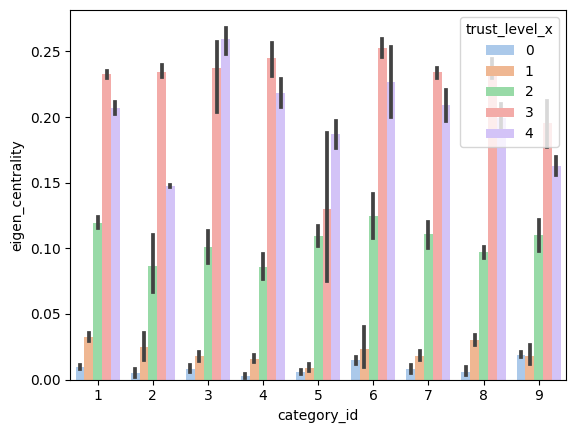

In [41]:
df2 = df.merge(graph_df, how = "left", left_on = "username", right_on = "index")
sns.barplot(data = df2, x = "category_id", y = "eigen_centrality", hue = "trust_level_x", palette = "pastel", errorbar=None)

### Directed Network
Considering a directed version of the above reply network can offer more insights and makes more sense when thinking about discourse networks

In [42]:
graph.user_graph_directed()
graph.remove_nan_nodes() # if post wasnt a reply -> quite frequently, will have to find a way of including these
graph.remove_isolated_nodes() # remove isolated nodes -> nodes that only interacted with themselves (or never)
graph.add_trust_level()
G = graph.get_graph()
eigen = nx.eigenvector_centrality(graph.get_graph())
degree = dict(G.degree())
out_degree = dict(G.out_degree())
in_degree = dict(G.in_degree())
var_list = [eigen, degree, out_degree, in_degree]
name_list = ['eigen_centrality', 'degree','out_degree', 'in_degree']
for counter, item in enumerate(var_list):
    nx.set_node_attributes(G, item, name = name_list[counter])
graph_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()

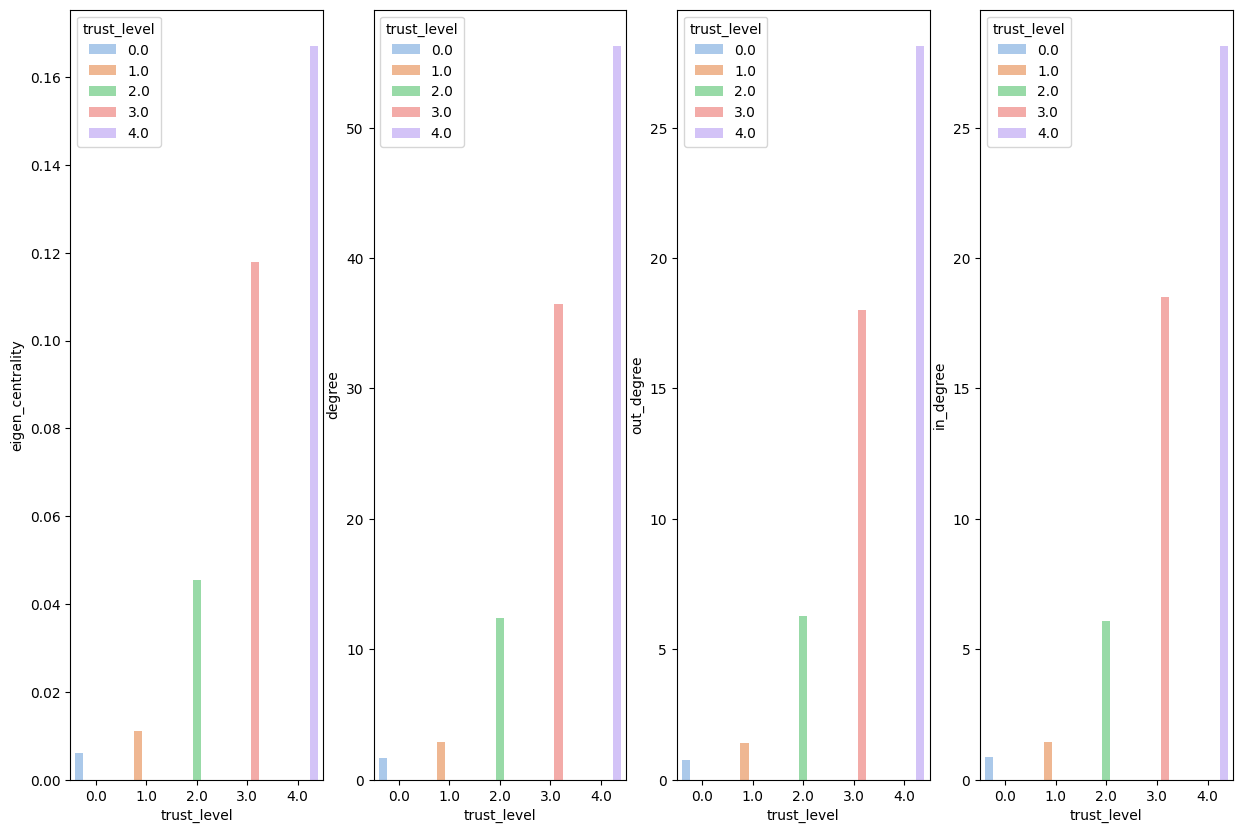

In [45]:
fig, ax =plt.subplots(1,4, figsize = (15,10))
for counter, variable in enumerate(name_list):
    sns.barplot(data = graph_df, x = "trust_level", y = variable, hue = "trust_level",
           palette = "pastel", ax = ax[counter], errorbar=None)


No difference to undirected? Either a problem in the code or in the way the data is constructed.
Cant find any `reference_to` column like in other papers. We would have to work with a better version of creating a graph